#**Assignment**

Based on the analysis performed in this notebook, the assignment is to focus on building and evaluating models for predicting the **High** price of the NIFTY 50 index.

Specifically, you should concentrate on the following models and time windows:

*   **Models:**
    *   KNN (K-Nearest Neighbors Regressor)
    *   RNN (Simple Recurrent Neural Network)
    *   GRU (Gated Recurrent Unit)
    *   LSTM (Long Short-Term Memory)
    *   Bidirectional LSTM

*   **Time Windows (Input Days):**
    *   30 days
    *   60 days
    *   90 days

For the Deep Learning models (RNN, GRU, LSTM, Bidirectional LSTM), train them for **50 epochs**.

The goal is to train these specific models for the 'High' column using the specified time windows and evaluate their performance using MAE and RMSE, comparing the results.

In [1]:
from google.colab import files
uploaded = files.upload()

Saving dataset.csv to dataset.csv


Load Dataset

In [2]:
import pandas as pd
df = pd.read_csv("dataset.csv")
df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6315 entries, 0 to 6314
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    6315 non-null   object 
 1   Open    6315 non-null   float64
 2   High    6315 non-null   float64
 3   Low     6315 non-null   float64
 4   Close   6315 non-null   float64
dtypes: float64(4), object(1)
memory usage: 246.8+ KB


,Date,Open,High,Low,Close
0,2000-01-03,1482.15,1592.90,1482.15,1592.2
1,2000-01-04,1594.40,1641.95,1594.40,1638.7
2,2000-01-05,1634.55,1635.50,1555.05,1595.8
3,2000-01-06,1595.80,1639.00,1595.80,1617.6
4,2000-01-07,1616.60,1628.25,1597.20,1613.3


Import Libraries

In [3]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from copy import deepcopy


from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings("ignore")

Data Filtering

In [4]:
def return_pairs(column, days):
    prices = list(column)
    X = []
    y = []
    for i in range(len(prices) - days):
        X.append(prices[i:i+days])
        y.append(prices[i+days])
    return np.array(X), np.array(y)

target_columns = ['Open', 'Close', 'High', 'Low']
day_chunks = [30, 45, 60, 90, 120, 150, 200, 250]
chunked_data = {}

for col in target_columns:
    for days in day_chunks:
        key_X = f"X_{col}_{days}"
        key_y = f"y_{col}_{days}"
        X, y = return_pairs(df[col], days)
        chunked_data[key_X] = X
        chunked_data[key_y] = y

all_chunk_pairs = []
for key in chunked_data.keys():
    if key.startswith("X_"):
        y_key = key.replace("X_", "y_")
        if y_key in chunked_data:
            all_chunk_pairs.append([key, y_key])

# filter down to only the data asked
assignment_target = 'High'
assignment_windows = [30, 60, 90]
assignment_chunk_pairs = []

for X_key, y_key in all_chunk_pairs:
    _, target, window = X_key.split('_')
    if target == assignment_target and int(window) in assignment_windows:
        assignment_chunk_pairs.append([X_key, y_key])

print("Filtered Data Pairs for the Assignment:")
print(assignment_chunk_pairs)

Filtered Data Pairs for the Assignment:
[['X_High_30', 'y_High_30'], ['X_High_60', 'y_High_60'], ['X_High_90', 'y_High_90']]


 Defining the Model

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Bidirectional
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor

def build_rnn(input_shape):
    model = Sequential([
        SimpleRNN(50, activation='tanh', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_lstm(input_shape):
    model = Sequential([
        LSTM(50, activation='tanh', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_gru(input_shape):
    model = Sequential([
        GRU(50, activation='tanh', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_bilstm(input_shape):
    model = Sequential([
        Bidirectional(LSTM(50, activation='tanh'), input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [6]:
# ML model
assignment_ml_models = [
    ("KNN", KNeighborsRegressor())
]

# DL models
assignment_dl_models = {
    "RNN": build_rnn,
    "LSTM": build_lstm,
    "GRU": build_gru,
    "Bidirectional_LSTM": build_bilstm
}

print("ML Models for Assignment:")
print([name for name, model in assignment_ml_models])
print("\nDL Models for Assignment:")
print(list(assignment_dl_models.keys()))

ML Models for Assignment:
['KNN']

DL Models for Assignment:
['RNN', 'LSTM', 'GRU', 'Bidirectional_LSTM']


Train the Models

In [8]:
results = {}

for X_key, y_key in tqdm(assignment_chunk_pairs, desc="Processing Time Windows"):

    # Get the data for the current pair
    X_data = chunked_data[X_key]
    y_data = chunked_data[y_key]

    X_train, X_test, y_train, y_test = train_test_split(
        X_data, y_data, test_size=0.1, random_state=42
    )

    # KNN
    for model_name, model in tqdm(assignment_ml_models, desc=f"ML Models for {X_key}"):
        key = f"{model_name}_{X_key[2:]}"
        model_copy = deepcopy(model)
        model_copy.fit(X_train, y_train)

        y_train_pred = model_copy.predict(X_train)
        y_test_pred = model_copy.predict(X_test)

        results[key] = {
            'model_type': 'ML',
            'train_mae': mean_absolute_error(y_train, y_train_pred),
            'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
            'test_mae': mean_absolute_error(y_test, y_test_pred),
            'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred))
        }

    # DL Models
    X_train_dl = np.expand_dims(X_train, -1)
    X_test_dl = np.expand_dims(X_test, -1)

    for model_name, builder in tqdm(assignment_dl_models.items(), desc=f"DL Models for {X_key}"):
        key = f"{model_name}_{X_key[2:]}"
        model_dl = builder((X_train_dl.shape[1], 1))

        # Train for 50 epochs
        model_dl.fit(X_train_dl, y_train, epochs=30, batch_size=8, verbose=0)

        y_train_pred_dl = model_dl.predict(X_train_dl).flatten()
        y_test_pred_dl = model_dl.predict(X_test_dl).flatten()

        results[key] = {
            'model_type': 'DL',
            'train_mae': mean_absolute_error(y_train, y_train_pred_dl),
            'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred_dl)),
            'test_mae': mean_absolute_error(y_test, y_test_pred_dl),
            'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred_dl))
        }

print("\nTraining Complete!")

Processing Time Windows:   0%|          | 0/3 [00:00<?, ?it/s]

ML Models for X_High_30:   0%|          | 0/1 [00:00<?, ?it/s]

DL Models for X_High_30:   0%|          | 0/4 [00:00<?, ?it/s]

177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ML Models for X_High_60:   0%|          | 0/1 [00:00<?, ?it/s]

DL Models for X_High_60:   0%|          | 0/4 [00:00<?, ?it/s]

176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


ML Models for X_High_90:   0%|          | 0/1 [00:00<?, ?it/s]

DL Models for X_High_90:   0%|          | 0/4 [00:00<?, ?it/s]

176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Training Complete!


Analyze and Visualize Results

In [9]:
results_df = pd.DataFrame.from_dict(results, orient='index')

results_df['window'] = [int(i.split('_')[-1]) for i in results_df.index]
results_df['model_name'] = [i.split('_')[0] for i in results_df.index]

print("Model Performance Results")
display(results_df.sort_values(by='test_mae', ascending=True))

Model Performance Results


,model_type,train_mae,train_rmse,test_mae,test_rmse,window,model_name
KNN_High_90,ML,36.929140,58.769966,48.790144,74.204848,90,KNN
KNN_High_60,ML,36.850899,58.333589,52.819089,82.674612,60,KNN
KNN_High_30,ML,42.646429,68.669169,56.933037,89.679421,30,KNN
RNN_High_30,DL,6914.346134,9333.960873,6395.763221,8919.789746,30,RNN
RNN_High_60,DL,6942.268330,9366.449850,6460.708463,8859.774438,60,RNN
RNN_High_90,DL,6960.019710,9371.817316,6660.687172,9081.764515,90,RNN
Bidirectional_LSTM_High_30,DL,7320.765504,9641.025802,6801.580323,9217.597265,30,Bidirectional
GRU_High_60,DL,7338.045607,9665.556966,6856.535794,9154.465635,60,GRU
Bidirectional_LSTM_High_60,DL,7407.139418,9718.116715,6925.629605,9206.329529,60,Bidirectional
GRU_High_30,DL,7452.421022,9741.373108,6933.235841,9315.168472,30,GRU


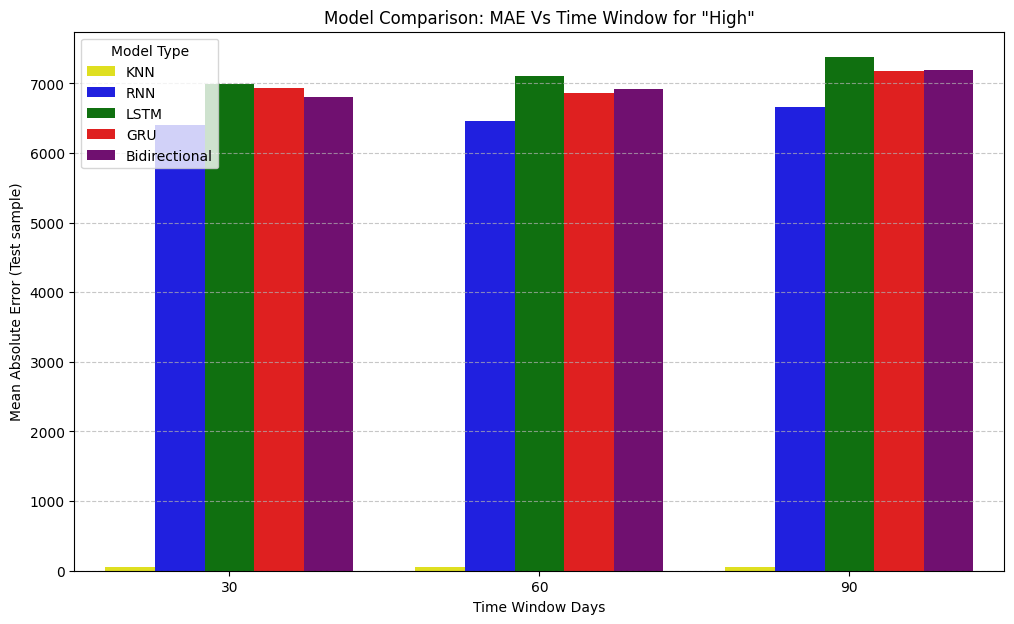

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 7))
palette_map = {
    'KNN': 'yellow',
    'RNN': 'blue',
    'LSTM': 'green',
    'GRU': 'red',
    'Bidirectional': 'purple'
}

sns.barplot(
    x='window',
    y='test_mae',
    hue='model_name',
    data=results_df,
    palette=palette_map
)

plt.title('Model Comparison: MAE Vs Time Window for "High"')
plt.xlabel('Time Window Days')
plt.ylabel('Mean Absolute Error (Test sample)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Model Type')
plt.show()


# **Insights**
- KNN is outperforming DL models — which is unusual, but indicates:

- DL models may be underfitting/overfitting due to:

- Insufficient data preprocessing (scaling/normalization missing?)

- Training hyperparameters not tuned (epochs, learning rate, sequence length).

- Model complexity too high for dataset size.

Window size impact:

- For KNN, larger windows (90 days) gave the best performance (lowest test RMSE = ~74).

- For DL models, increasing window size did not help; errors stayed extremely high.

- KNN (classical ML) is currently the best-performing model for this dataset.

- Deep learning models failed due to poor preprocessing/hyperparameter setup, not because they are inherently worse.